# Transfer Learning use case: Bears

#### Deep Learning. Máster Big Data & Data Science, UCM
#### Autora: María Luisa Duque García
#### E-mail: marialdu@ucm.es
#### Junio 2020

En el presente notebook vamos a tratar de llevar a cabo el reconocimiento de imagenes, en este caso optaremos por la identificación de osos con tres categorías (black, grizzly y teddy), el problema a resolver consiste en identificar y clasificar los objetos/imagen (la clase a la que pertenece cada oso, en este caso tres clases).

Los modelos que vamos a utilizar son conocidos como Convolutional Neuronal Networks (CNNs), redes neuronales convolucionales. Las CNNs aprenden a responder a diferentes caractegorías de la imagen (bordes, formas, etc), como los bancos de filtros utilizados en los algoritmos tradicionales y/o definidos de forma manual.

Existen ya modelos entrenados de reconocimiento de imagen disponibles, diferentes arquitecturas de CNNs accesibles (desde el módulo keras.applications) que pueden alcanzar un rendimiento razonable para esta tarea. Keras, una librería de alto nivel que sirve como capa de abstracción sobre Tensorflow, proporciona diversas arquitecturas que pueden ser implementadas para nuestro objetivo Transfer Learning, algunas de ellas son VGG16, VGG19, InceptionV3, Xception, InceptionResNetV2, DenseNet, NasNet, SPDNets, ResNet50, MobileNet, MobileNetV2, etc., [en Keras.io pueden ser encontrados los modelos disponibles](https://keras.io/api/applications/).

En la presente tarea, y dado su carácter didáctico, vamos a realizar tres modelos principales haciendo uso de las arquitecturas VGG16, MobilNet e InceptionV3. A continación, cubriremos los siguientes puntos:

1. Importamos librerías
2. Cargamos imagenes
3. Arquitectura y Creación del Modelo
    - **VGG16**
        - Creación del Modelo
        - Congelación de capas
        - Creación de sets train y test
        - Compilación y Entrenamiento del Modelo
        - Resultados check
        - Curvas de aprendizaje
        - ¿Hay sobreajuste?
        - Model save and load
        - Predicciones: Test sobre imagenes
    - **MobileNet**
        - Importación del modelo pre-entrenado y agregación de las capas
        - Carga de los datos de train y validation con ImageDataGenerator
        - Resultados check y curvas de aprendizaje
        - Model save y load
        - Predicciones: Test sobre imagenes 
    - **InceptionV3**
        - Importación del modelo pre-entrenado y agregación de las capas
        - Carga de los datos de train y validation con ImageDataGenerator
        - Resultados check y curvas de aprendizaje
        - Model save y load
        - Predicciones: Test sobre imagenes 
4. Conclusiones

### El Dataset

Nuestro dataset está compuesto por 240 imagenes de osos:
- Black
- Grizzly
- Teddy (oso de peluche)

Está estructurado en carpetas, carpetas que vamos a relacionar con etiquetas, la variable objetivo será así el directorio en el que está.

Cada carpeta contiene 80 imagenes por cada una de las tres clases; por tanto, nuestro dataset está balanceado y no presentará problemas en la parte del entrenamiento.

## 1. Importamos librerías

In [1]:
import os
import pandas as pd
import numpy as np
import keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

#tf.get_logger().setLevel('ERROR')
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.clear_session()  # Para un sencillo restablecimiento del estado del Notebook

from tensorflow.keras.preprocessing import image
from tensorflow.python.keras import applications
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet, VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16 
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from numpy import expand_dims
import matplotlib.pyplot as plt
from keras.applications.vgg16 import decode_predictions

Using TensorFlow backend.


## 2. Cargamos imagenes

Utilizamos una ruta base (base_path) que es donde se encuentran las imagenes.

In [2]:
base_path = 'C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets/practicas/osos' 

Cargamos algunas imagenes a modo de ejemplo.

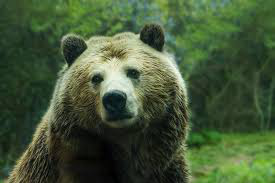

In [3]:
image.load_img(base_path + '/grizzly/00000045.jpg')

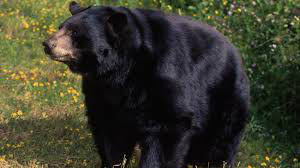

In [4]:
image.load_img('../datasets/practicas/osos/black/00000042.jpg')

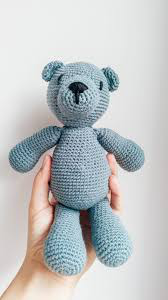

In [5]:
image.load_img('../datasets/practicas/osos/teddys/00000053.jpg')

## 3. Arquitectura y Creación del Modelo

### VGG16

VGG6 network se trata de una arquitectura de modelo que ya se encuentra preentrenado (ya optimizada para la detección de ciertas features), red entrenada en imagenet con la arquitectura VGG16. Imagenet se trata de un dataset general con más de un millón de imagenes y muy diversas categorías (más de 1000).

Lo que vamos a realizar es lo siguiente:

- Añadiremos una capa average pooling (usa la media) después de la estructura preentrenada.
- Añadiremos tres capas densas, dos con 1024 unidades y dos con 512 unidades, usaremos la función de activación tipo 'relu'.
- La capa final será otra capa densa totalmente conectada con el número de clases y activación tipo 'softmax'.

In [6]:
# Veamos primero que contiene VGG16
vgg=applications.vgg16.VGG16()
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Vemos que la última capa de predictions tiene 1000 elementos, hecho que no queremos, ya que nosotros sólo requieremos predecir tres clases de oso.

In [7]:
# Definimos el modelo base
# Importamos el modelo VGG16 y los pesos de entranamiento de 'imagenet'
# Descartamos la última capa (la clasificación en 1000 categorias de 'imagenet) incluyendo 'include_top=False'
base_model=VGG16(weights='imagenet',include_top=False)

In [8]:
# Estructura del modelo, usamos la forma funcional para definirla, añadimos capas, cada capa será una función

# Definimos el output del modelo base
x=base_model.output 

# Añadimos una segunda capa average pooling
x=GlobalAveragePooling2D()(x) 

# Agregamos capas densas para que el modelo pueda aprender funciones más complejas y obtener mejores resultados
x=Dense(1024,activation='relu')(x) # Capa densa 1
x=Dense(1024,activation='relu')(x) # Capa densa 2
x=Dense(512,activation='relu')(x) #Capa densa 3

# Predicciones, una capa densa con activación 'softmax'
preds=Dense(3,activation='softmax')(x)

#### Creación del Modelo

El input será la capa input del modelo base VGG16 y el output será la capa definida como 'preds'.

In [9]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

El modelo tiene diversas capas propias de la VGG16 (conv-pool; VGG16 tiene 16 capas genéricas, vemos algunas que no tienen parámetros) y las cinco últimas capas del modelo son las que hemos añadido anteriormente (cinco capas, pero en realidad tenemos cuatro con parámetros). Nos quedamos con las capas de VVG16 (transfer learning) más las nuevas capas creadas.

In [10]:
# El modelo base tiene 19 capas, longitud
len (base_model.layers)

19

In [11]:
# Nuestro modelo tiene 24 ya que le hemos añadido las 5 últimas
len(model.layers)

24

#### Congelación de capas

Tenemos infinidad de parámetros, entrenar tantos es muy costoso e incluso ineficiente, para que las capas aprendan y convergan debemos congelar las primeras capas. Las últimas capas son las que únicamente deben aprender. Además, tecnicamente las capas del VGG16 ya aprendieron en el pasado, no necesitamos ni requerimos que aprendan ahora ni se modifiquen sus pesos.

In [12]:
# Escogemos las primeras 19 capas, las 5 últimas (en realidad 4) las dejamos para testear, con estas enseñamos al modelo
for layer in model.layers[:19]:
    layer.trainable=False
for layer in model.layers[19:]:
    layer.trainable=True

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

Ahora tenemos 2,101,251 que son entrenables (los parámetros de nuestras cinco últimas capas); es decir, tenemos muchos parámetros congelados 14,714,688.

El backpropagation actualizará solamente aquellos parámetros que sean entrenables.

#### Creación de sets train y test

Creamos el generador de imagen, utilizamos ImageDataGenerator, especificamos que éste utilizará la función de entrada de preprocesado VVG16. ImageDataGenerator lleva a cabo transformaciones en los datos de la imagen para que el entrenamiento sea más genérico, modifica la imagen de entrada.

Agregamos también la función flow_from_directory para indicarle dónde se encuentran los datos, nuestras imagenes.

Optamos por dividir train/validation en un 80/20.

In [14]:
# Disponemos de nuestra ruta, donde se encuentran las imagenes, ya definida
base_path

'C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets/practicas/osos'

In [15]:
# Creamos train y test
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_vgg16, validation_split=0.2)

train_generator=train_datagen.flow_from_directory(base_path, 
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='training') # training data

validation_generator=train_datagen.flow_from_directory(base_path, 
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='validation') # validation data

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


#### Compilación y Entrenamiento del Modelo

Compilamos el modelo usando el optimizador 'Adam' y categorical Xentropy para la función de coste. Incluimos la métrica de 'accuracy'. Entrenamos el modelo para 15 epochs. 

Hemos definido train_generator y validation_generation con un batch_size de 64, ya que hemos comprobado que ofrece los mejores resultados para este modelo. Habitualmente, los batch_size más óptimos son 32, 64, 128 o 256; hemos comprobado que con un batch_size de 32 el modelo no ofrece curvas de aprendizaje óptimas, esencialmente, Validation Loss fluctúa en demasía, por otro lado, un batch_size de 128 es demasiado alto para que Kernel funcione optimamente en este caso. 

In [16]:
# Compilación del modelo
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=validation_generator.n//validation_generator.batch_size

In [18]:
# Entrenamiento del modelo
history = model.fit_generator(
    train_generator,
    steps_per_epoch = step_size_train,
    validation_data = validation_generator, 
    validation_steps = step_size_validation,
    epochs = 15)

Epoch 1/15
3/3 [==============================] - 32s 11s/step - loss: 9.9270 - accuracy: 0.2969 - val_loss: 1.9240 - val_accuracy: 0.6875
Epoch 2/15
3/3 [==============================] - 31s 10s/step - loss: 1.8711 - accuracy: 0.7396 - val_loss: 2.8259 - val_accuracy: 0.6042
Epoch 3/15
3/3 [==============================] - 31s 10s/step - loss: 1.1659 - accuracy: 0.7656 - val_loss: 0.0401 - val_accuracy: 0.9792
Epoch 4/15
3/3 [==============================] - 32s 11s/step - loss: 0.2499 - accuracy: 0.9531 - val_loss: 0.0382 - val_accuracy: 0.9792
Epoch 5/15
3/3 [==============================] - 33s 11s/step - loss: 0.1237 - accuracy: 0.9688 - val_loss: 0.2820 - val_accuracy: 0.9583
Epoch 6/15
3/3 [==============================] - 34s 11s/step - loss: 0.0647 - accuracy: 0.9740 - val_loss: 0.5912 - val_accuracy: 0.9167
Epoch 7/15
3/3 [==============================] - 32s 11s/step - loss: 0.0724 - accuracy: 0.9688 - val_loss: 0.4441 - val_accuracy: 0.9583
Epoch 8/15
3/3 [===========

Otra opción alternativa de entrenamiento del modelo podría ser definir del siguiente modo los hiperparámetros (lo hemos probado pero no lo vamos a mostrar como resultado, optamos por exponer estos detalles en Raw NBConvert para dejarlo constar).

In [19]:
# History permite pintar nuestros resultados
history.history.keys() 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

#### Resultados check

Chequeamos el accuracy del modelo y resto de resultados.

In [20]:
score = model.evaluate(validation_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3349003493785858
Test accuracy: 0.9583333134651184


In [21]:
print('Test error:', 100 * (1 - score[1]), "%")

Test error: 4.166668653488159 %


*Nota.- El resultado de Test error más óptimo sería aquel por debajo o igual a 0,21% para modelos más complejos que el aquí tratado*

#### Curvas de aprendizaje

Vamos a observar las curvas de aprendizaje de train y validation accuracy/loss de nuestro modelo.

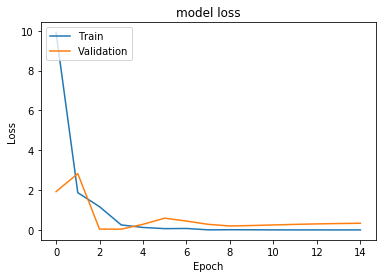

In [22]:
# Visualización de loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

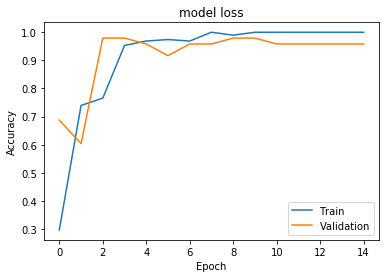

In [23]:
# Visualización de accuracy
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

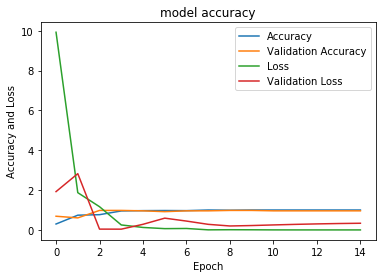

In [24]:
# Visualización conjunta
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

#### ¿Hay sobreajuste?

Podemos evaluar si hay sobreajuste basandonos en:

1. Si hay mucha diferencia en el rango de valores de la métrica accuracy de train y la métrica val_accuracy de validación, existiría sobreajuste

2. Cuando la función de coste en validación, Validation Loss, empieza a crecer también existiría sobreajuste, aunque hay que tener siempre en cuenta que la misma puede oscilar y no quiere decir que esté sobreajustando.


En nuestro modelo, las curvas de accuracy son óptimas y, también, nos resultan bastante satisfactorias las curvas de costes. Podríamos incluso considerar usar un número de epochs más bajo, de 11 o 12 por ejemplo. 

#### Model save and load

Los modelos de Deep Learning necesitan tiempo para ser entrenados por lo que es útil guardar sus pesos o incluso el modelo completo.

#### Weights save

Guardamos sólo los pesos del modelo.

In [25]:
model.save_weights('../models/bearsconvvgg16.h5')

#### Model save

Guardamos el modelo entero.

In [26]:
model.save ('../models/modelbearsvgg16.h5')

#### Weight load

In [27]:
model.load_weights ('../models/bearsconvvgg16.h5')

#### Model load

Para cargar el modelo entero.

In [28]:
from tensorflow.keras.models import load_model
model = load_model ('../models/modelbearsvgg16.h5')

#### Predicciones: Test sobre imagenes

Metodologicamente lo ideal sería poder disponer de tres muestras (train, validation y test), disponer de otro conjunto test para poder realizar las predicciones; sin embargo, únicamente disponemos de 240 imagenes, son demasiado pocas, el tamaño de los datos en nuestro dataset no es suficiente como para crear otro conjunto test. Consideramos que lo más óptimo es descargarnos imagenes variadas de internet y usarlas como nuestro dataset de test.

A continuación, vamos a crear una función para testear el modelo sobre las imagenes descargadas, éstas han sido guardadas en una nueva carpeta llamada test, predeciremos así imagenes sobre un directorio dado.

In [29]:
# Diccionario para las clases
class_dict = {v:k for k, v in train_generator.class_indices.items()}

In [30]:
class_dict

{0: 'black', 1: 'grizzly', 2: 'teddys'}

In [31]:
# Por cada directorio, las clases
train_generator.class_indices

{'black': 0, 'grizzly': 1, 'teddys': 2}

In [32]:
# Definimos la función de predicción
def predict_image(path):
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_vgg16(data) # importantisimo preprocesar
    preds = model.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    print(pred)
    print(preds)
    print('La probabilidad de 0 a 1 de que sea {} es: '.format(pred) +str(np.max(preds)))
    return img

Utilizamos una ruta de predicción (pred_path) que es donde se encuentran las imagenes a predecir de test.

In [33]:
pred_path = 'C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets/'

Predecimos algunas imagen a continuación.

grizzly
[[1.4178481e-11 1.0000000e+00 3.6002143e-17]]
La probabilidad de 0 a 1 de que sea grizzly es: 1.0


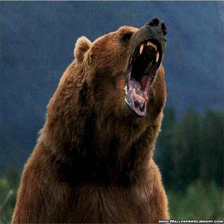

In [34]:
predict_image(pred_path + '/test/22.jpg')

black
[[9.9999762e-01 2.3421799e-06 1.1917329e-12]]
La probabilidad de 0 a 1 de que sea black es: 0.9999976


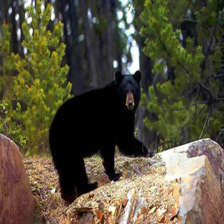

In [35]:
predict_image(pred_path + '/test/30.jpg')

teddys
[[3.1820366e-09 2.1509934e-12 1.0000000e+00]]
La probabilidad de 0 a 1 de que sea teddys es: 1.0


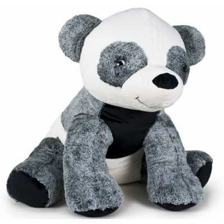

In [36]:
predict_image(pred_path + '/test/10.jpg')

teddys
[[4.3720874e-19 6.7779308e-18 1.0000000e+00]]
La probabilidad de 0 a 1 de que sea teddys es: 1.0


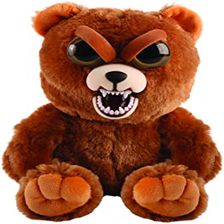

In [37]:
predict_image(pred_path + '/test/8.jpg') 

El modelo parece predecir optimamente nuestras imagenes.

Generaremos una predicción para todas las imagenes de la carpeta test del siguiente modo.

In [38]:
import os
path = pred_path + '/test'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            print(new_path)
            predict_image(new_path)

C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\1.jpg
black
[[9.9999630e-01 3.7461698e-06 9.0231286e-15]]
La probabilidad de 0 a 1 de que sea black es: 0.9999963
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\10.jpg
teddys
[[3.1820366e-09 2.1509934e-12 1.0000000e+00]]
La probabilidad de 0 a 1 de que sea teddys es: 1.0
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\11.jpg
grizzly
[[0.17343086 0.6325795  0.19398965]]
La probabilidad de 0 a 1 de que sea grizzly es: 0.6325795
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\12.jpg
grizzly
[[6.4382739e-08 9.9999988e-01 5.9698374e-16]]
La probabilidad de 0 a 1 de que sea grizzly es: 0.9999999
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\13.jpg
grizzly
[

### MobileNet

El modelo que usaremos ahora, para clasificar nuestras imagenes, será MobileNet.

MobileNet es otro modelo que ofrece una precisión de clasificación de imagenet razonablemente buena.

In [39]:
# Cargamos las librerías (consideramos ofrecer el modelo comenzando desde el inicio)
import numpy as np
import os
import keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import tensorflow as tf

# Restablecimiento del estado del notebook
tf.keras.backend.clear_session()

from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import RMSprop
from keras.optimizers import Adam

In [40]:
# Fijamos la ruta base
base_path2 = 'C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets/practicas/osos' 

#### Importación del modelo pre-entrenado y agregación de las capas

Usaremos aquí los pesos de imagenet, como anteriormente.

A continuación, importaremos el modelo MobileNet sin su última capa y agregamos algunas capas densas para que nuestro modelo pueda aprender funciones más complejas. Las capas densas tendrán la función de activación relu y la última capa, que contiene tantas neuronas como el número de clases, tendrá la activación tipo softmax.

In [41]:
# Importamos el MobilNet y descartamos la última capa de 1000 neuronas con IncludeTop = False 
base_model2=MobileNet(weights='imagenet',include_top=False)
base_model2.summary()

C:\Users\maria\anaconda3\envs\master\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

Usamos la forma funcional para definir la estructura del modelo, es decir, cada capa será una función.

In [42]:
# Estructura del modelo
y=base_model2.output
y=GlobalAveragePooling2D()(y)
# Agregamos capas densas para que el modelo pueda aprender funciones más complejas y obtener mejores resultados
y=Dense(1024,activation='relu')(y) # Capa densa 1
y=Dense(1024,activation='relu')(y) # Capa densa 2
y=Dense(512,activation='relu')(y) #Capa densa 3
preds2=Dense(3,activation='softmax')(y) # Capa final de predicción con activación softmax

In [43]:
# Especificamos inputs y outputs para terminar de crear el modelo en base a la arquitectura escogida
model2=Model(inputs=base_model2.input,outputs=preds2)

In [44]:
len (base_model2.layers)

87

In [45]:
len (model2.layers)

92

In [46]:
for layer in model2.layers[:87]:
    layer.trainable=False
for layer in model2.layers[87:]:
    layer.trainable=True

In [47]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

#### Carga de los datos de train y validation 

Haremos uso, como anteriormente, de ImageDataGenerator y la función de preprocesado de MobilNet que hemos importado como preprocess_input en este caso.

Usamos un train/validation de 80/20.

In [48]:
train_datagen2=ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_generator2=train_datagen2.flow_from_directory(base_path2, 
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='training') # training data

validation_generator2=train_datagen2.flow_from_directory(base_path2, 
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='validation') # validation data

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


**Compilamos y entrenamos el modelo**


Tras varias pruebas, consideramos que el modelo ofrece los mejores resultados usando 14 epochs con optimizador Adam.

In [49]:
# Compilación del modelo
model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train2=train_generator2.n//train_generator2.batch_size
step_size_validation2=validation_generator2.n//validation_generator2.batch_size

# Entrenamiento del modelo
history2 = model2.fit_generator(
    train_generator2,
    steps_per_epoch = step_size_train2,
    validation_data = validation_generator2, 
    validation_steps = step_size_validation2,
    epochs = 14)

Epoch 1/14
3/3 [==============================] - 24s 8s/step - loss: 1.7993 - accuracy: 0.4896 - val_loss: 1.2525 - val_accuracy: 0.5000
Epoch 2/14
3/3 [==============================] - 20s 7s/step - loss: 0.7724 - accuracy: 0.6510 - val_loss: 0.4204 - val_accuracy: 0.6667
Epoch 3/14
3/3 [==============================] - 20s 7s/step - loss: 0.3396 - accuracy: 0.7917 - val_loss: 0.2059 - val_accuracy: 0.9375
Epoch 4/14
3/3 [==============================] - 20s 7s/step - loss: 0.1882 - accuracy: 0.9583 - val_loss: 0.1538 - val_accuracy: 0.9375
Epoch 5/14
3/3 [==============================] - 20s 7s/step - loss: 0.0986 - accuracy: 0.9635 - val_loss: 0.0443 - val_accuracy: 0.9792
Epoch 6/14
3/3 [==============================] - 21s 7s/step - loss: 0.0675 - accuracy: 0.9792 - val_loss: 0.0374 - val_accuracy: 0.9792
Epoch 7/14
3/3 [==============================] - 21s 7s/step - loss: 0.0453 - accuracy: 0.9844 - val_loss: 0.0715 - val_accuracy: 0.9792
Epoch 8/14
3/3 [==================

Se ha probado también a usar como optimizador RSMprop y diversos epochs (hecho que no vamos a mostrar en los resultado pero dejamos constancia en Raw NBConvert).

#### Resultados check y curvas de aprendizaje

In [50]:
# Resultados
score = model2.evaluate(validation_generator2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test error:', 100 * (1 - score[1]), "%")

Test loss: 0.007036340888589621
Test accuracy: 1.0
Test error: 0.0 %


Los resultados mejoran considerablemente con respecto al modelo anterior con VGG16. De hecho en este caso, el test error logrado es del 0% y el accuracy de 1, unos resultados que son perfectos, este hecho es llamativo sin ninguna duda y cabría dudar o al menos plantearse su perfección, como nuestro fin es didáctivo dejamos ofrecidos estos resultados.

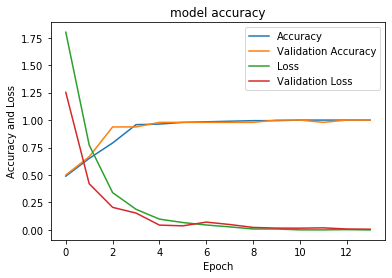

In [51]:
# Curvas de aprendizaje: visualización conjunta
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

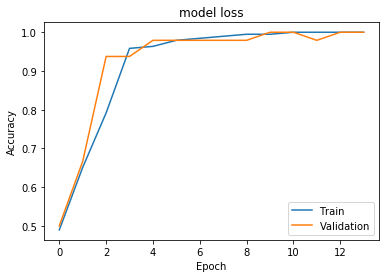

In [52]:
# Visualización de accuracy
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

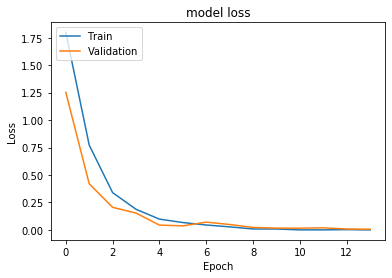

In [53]:
# Visualización de loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#### ¿Hay sobreajuste?

Escogiendo 14 epochs, optimizador Adam, batch_size 64, y tras las métricas de resultados obtenidas parece no existir sobreajuste alguno, como cabía esperar. Las curvas de aprendizaje son realmente óptimas.

#### Model save y load

Guardamos este modelo MobilNet.

In [54]:
# Grabado
model2.save_weights('../models/bearsconvmobilnet.h5')
model2.save ('../models/modelbearsmobilnet.h5')
# Carga
model2.load_weights ('../models/bearsconvmobilnet.h5')

#### Predicciones: Test sobre imagenes

Como anteriormente, realizamos las predicciones sobre la carpeta test donde hemos descargado imagenes variadas de internet.

In [55]:
# Diccionario para las clases
class_dict2 = {v:k for k, v in train_generator2.class_indices.items()}

# Definimos la función de predicción
def predict_image2(path):
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_input(data) # importantisimo preprocesar
    preds2 = model2.predict(data)
    pred2 = np.argmax(preds2)
    pred2 = class_dict[pred2]
    print(pred2)
    print(preds2)
    print('La probabilidad de 0 a 1 de que sea {} es: '.format(pred2) +str(np.max(preds2)))
    return img

grizzly
[[6.4382739e-08 9.9999988e-01 5.9698374e-16]]
La probabilidad de 0 a 1 de que sea grizzly es: 0.9999999


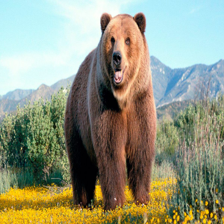

In [56]:
# Ruta para las predicciones
pred_path = 'C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets/'

# Predicción de imagen
predict_image(pred_path + '/test/12.jpg') 

black
[[9.9999964e-01 3.2856158e-07 8.1764185e-13]]
La probabilidad de 0 a 1 de que sea black es: 0.99999964


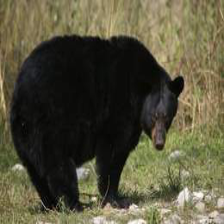

In [57]:
predict_image(pred_path + '/test/17.jpg') 

teddys
[[8.8783290e-14 1.6941735e-15 1.0000000e+00]]
La probabilidad de 0 a 1 de que sea teddys es: 1.0


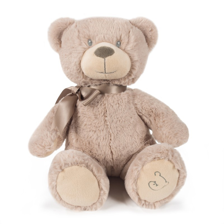

In [58]:
predict_image(pred_path + '/test/7.jpg') 

La predicción de las imagenes escogidas es óptima.

In [59]:
# Predicción de todas las imagenes de la carpeta test
import os
path = pred_path + '/test'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            print(new_path)
            predict_image(new_path)

C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\1.jpg
black
[[9.9999630e-01 3.7461698e-06 9.0231286e-15]]
La probabilidad de 0 a 1 de que sea black es: 0.9999963
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\10.jpg
teddys
[[3.1820366e-09 2.1509934e-12 1.0000000e+00]]
La probabilidad de 0 a 1 de que sea teddys es: 1.0
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\11.jpg
grizzly
[[0.17343086 0.6325795  0.19398965]]
La probabilidad de 0 a 1 de que sea grizzly es: 0.6325795
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\12.jpg
grizzly
[[6.4382739e-08 9.9999988e-01 5.9698374e-16]]
La probabilidad de 0 a 1 de que sea grizzly es: 0.9999999
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\13.jpg
grizzly
[

### InceptionV3

InceptionV3 es una red neuronal convolucional con 48 capas de profundidad desarrollada por Google Search.

Vamos a hacer uso de esta arquitectura para ver qué tal clasifica y reconoce nuestras imagenes. 

In [60]:
# Cargamos las librerías (consideramos ofrecer el modelo empezando desde el inicio)
import numpy as np
import os
import keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import tensorflow as tf

# Restablecimiento del estado del notebook
tf.keras.backend.clear_session()

from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input as preprocess_inceptionv3
from keras.applications.inception_v3 import decode_predictions

In [61]:
# Fijamos la ruta base
base_path3 = 'C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets/practicas/osos'

#### Importación del modelo pre-entrenado y agregación de las capas

In [62]:
# Importamos InceptionV3 y descartamos la última capa, IncludeTop = False 
base_model3=InceptionV3(weights='imagenet', include_top=False)
base_model3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

En esta ocasión, vamos a optar por incluir un menor número de capas densas en nuestra estructura. Vamos a incorporar solamente una capa densa con 512 unidades y activación relu, y una última capa de predicción densa con activación softmax.

In [63]:
# Estructura del modelo, usamos la forma funcional para definirla, añadimos capas, cada capa será una función

# Definimos el output del modelo base
z=base_model3.output 

# Añadimos una segunda capa average pooling
z=GlobalAveragePooling2D()(z) 

# Añadimos una tercera capa densa con activación 'relu'
z=Dense(512,activation='relu')(z) 

# Predicciones, una capa densa con acdtivación 'softmax'
preds3=Dense(3,activation='softmax')(z)

In [64]:
model3=Model(inputs=base_model3.input,outputs=preds3)
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

conv2d_61 (Conv2D)              (None, None, None, 1 147456      mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, None, None, 1 258048      activation_63[0][0]              
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, None, None, 1 258048      activation_68[0][0]              
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, None, None, 1 147456      average_pooling2d_7[0][0]        
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, None, None, 1 576         conv2d_61[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [65]:
# El modelo base tiene 19 capas, longitud
len (base_model3.layers)

311

In [66]:
# Nuestro modelo tiene 22 ya que le hemos añadido las 3 últimas capas
len(model3.layers)

314

In [67]:
# Escogemos las primeras 19 capas, las 3 últimas (en realidad 2) las dejamos para testear, con estas enseñamos al modelo
for layer in model3.layers[:311]:
    layer.trainable=False
for layer in model3.layers[311:]:
    layer.trainable=True

In [68]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, None, None, 1 576         conv2d_51[0][0]                  
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, None, None, 1 576         conv2d_54[0][0]                  
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, None, None, 1 576         conv2d_59[0][0]                  
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, None, None, 1 576         conv2d_60[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)      (None, None, None, 1 0           batch_normalization_51[0][0]     
__________

#### Carga de los datos de train y validation

In [69]:
train_datagen3=ImageDataGenerator(preprocessing_function=preprocess_inceptionv3, validation_split=0.2)

train_generator3=train_datagen3.flow_from_directory(base_path3, 
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='training') # training data

validation_generator3=train_datagen3.flow_from_directory(base_path3, 
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='validation') # validation data

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


In [70]:
# Compilación del modelo
model3.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

step_size_train3=train_generator3.n//train_generator3.batch_size
step_size_validation3=validation_generator3.n//validation_generator3.batch_size

In [71]:
# Entrenamiento del modelo
history3 = model3.fit_generator(
    train_generator3,
    steps_per_epoch = step_size_train3,
    validation_data = validation_generator3, 
    validation_steps = step_size_validation3,
    epochs = 20)

Epoch 1/20
3/3 [==============================] - 24s 8s/step - loss: 1.2050 - accuracy: 0.4219 - val_loss: 1.0436 - val_accuracy: 0.6667
Epoch 2/20
3/3 [==============================] - 21s 7s/step - loss: 0.7271 - accuracy: 0.7240 - val_loss: 0.1406 - val_accuracy: 0.9375
Epoch 3/20
3/3 [==============================] - 18s 6s/step - loss: 0.3864 - accuracy: 0.8125 - val_loss: 0.1610 - val_accuracy: 0.9375
Epoch 4/20
3/3 [==============================] - 18s 6s/step - loss: 0.1915 - accuracy: 0.9323 - val_loss: 0.0860 - val_accuracy: 0.9375
Epoch 5/20
3/3 [==============================] - 19s 6s/step - loss: 0.1676 - accuracy: 0.9427 - val_loss: 0.0452 - val_accuracy: 0.9792
Epoch 6/20
3/3 [==============================] - 18s 6s/step - loss: 0.1156 - accuracy: 0.9635 - val_loss: 0.0738 - val_accuracy: 0.9792
Epoch 7/20
3/3 [==============================] - 17s 6s/step - loss: 0.0664 - accuracy: 0.9844 - val_loss: 0.1242 - val_accuracy: 0.9583
Epoch 8/20
3/3 [==================

#### Resultados check y curvas de aprendizaje

In [72]:
score = model3.evaluate(validation_generator3, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test error:', 100 * (1 - score[1]), "%")

Test loss: 0.17358680069446564
Test accuracy: 0.9583333134651184
Test error: 4.166668653488159 %


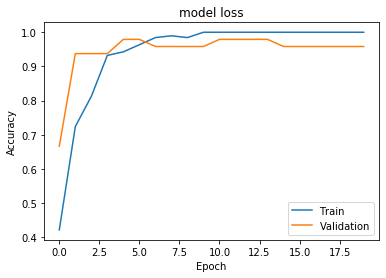

In [73]:
# Visualización de accuracy
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

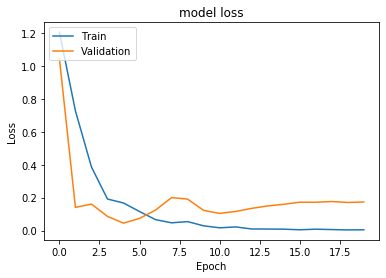

In [74]:
# Visualización de loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

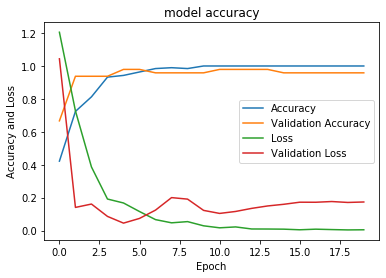

In [75]:
# Curvas de aprendizaje: visualización conjunta
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

En este caso, los resultado obtenidos son peores que con el modelo VGG16 y, por supuesto, que los obtenido con MobilNet. 

Esencialmente las curvas de coste de train y validación se encuentran más separadas que anteriomente. Muy probablemente este hecho sea debido a la estructura del modelo escogida en este caso.

#### Model save y load

In [76]:
# Grabado
model.save_weights('../models/bearsconvinceptionv3.h5')
model.save ('../models/modelbearsinceptionv3.h5')
# Carga
model.load_weights ('../models/bearsconvinceptionv3.h5')

#### Predicciones: Test sobre imagenes 

In [77]:
# Diccionario para las clases
class_dict3 = {v:k for k, v in train_generator3.class_indices.items()}

# Definimos la función de predicción
def predict_image3(path):
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_inceptionv3(data) # importantisimo preprocesar
    preds3 = model3.predict(data)
    pred3 = np.argmax(preds3)
    pred3 = class_dict[pred3]
    print(pred3)
    print(preds3)
    print('La probabilidad de 0 a 1 de que sea {} es: '.format(pred3) +str(np.max(preds3)))
    return img

grizzly
[[8.3202594e-06 9.9999166e-01 1.0485918e-08]]
La probabilidad de 0 a 1 de que sea grizzly es: 0.99999166


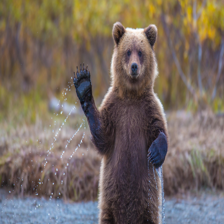

In [78]:
# Ruta para las predicciones
pred_path = 'C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets/'

# Predicción de una imagen
predict_image3(pred_path + '/test/20.jpg') 

black
[[9.9999583e-01 4.1992275e-06 7.1469053e-09]]
La probabilidad de 0 a 1 de que sea black es: 0.9999958


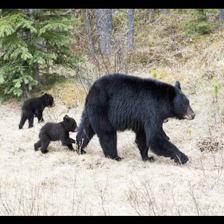

In [79]:
predict_image3(pred_path + '/test/26.jpg') 

teddys
[[2.0312536e-09 6.1436876e-06 9.9999380e-01]]
La probabilidad de 0 a 1 de que sea teddys es: 0.9999938


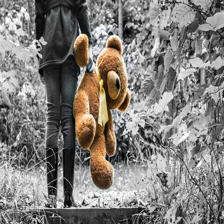

In [80]:
predict_image3(pred_path + '/test/11.jpg') 

Nuestro modelo con InceptionV3 predice correctamente.

In [81]:
# Predicción de las imagenes de la carpeta test
import os
path = pred_path + '/test'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            print(new_path)
            predict_image3(new_path)

C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\1.jpg
black
[[9.99999404e-01 5.60525734e-07 1.44063055e-08]]
La probabilidad de 0 a 1 de que sea black es: 0.9999994
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\10.jpg
teddys
[[2.5747926e-10 4.0436002e-10 1.0000000e+00]]
La probabilidad de 0 a 1 de que sea teddys es: 1.0
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\11.jpg
teddys
[[2.0312536e-09 6.1436876e-06 9.9999380e-01]]
La probabilidad de 0 a 1 de que sea teddys es: 0.9999938
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\12.jpg
grizzly
[[5.6609166e-05 9.9992764e-01 1.5782722e-05]]
La probabilidad de 0 a 1 de que sea grizzly es: 0.99992764
C:/Users/maria/Desktop/Temario Big Data/11 Deep Learning/online_deep_learning_intro-master/datasets//test\13.jp

## 4. Conclusiones

Tras la generación de modelos con VGG16, MobilNet e InceptionV3, escoger diversas estructuras e hiperparámetros.

A la luz de los datos, métricas y predicciones obtenidas, el modelo que ofrece aquí los mejores resultados es MobilNet (aunque, como hemos apuntado anteriormente demasiado perfectas y cabrá detenerse en ellas y sopesar su "perfección" de cara a futuros tratamientos más complejos); le siguen los resultados del modelo obtenido usando VGG16 y, por último, InceptionV3.